In [ ]:
import numpy as np 
import cv2
import mediapipe as mp
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# モジュールの準備
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=2)

In [7]:
def convert_deg(p1, p2):
  # 二点間の座標の差をとって傾きの角度を求める
  diff_x = p1[0] - p2[0]
  diff_y = p1[1] - p2[1]
  if diff_x != 0:
    tilt = diff_y / diff_x
    arctan = math.atan(tilt)
    return arctan

class ClassifyPolymesh:
  def __init__(self, pu, pr, pb, pl):
    self.pu = pu
    self.pr = pr
    self.pb = pb
    self.pl = pl
    
    self.array = [[0, 0], [0, 0], [0, 0], [0, 0]]
    
  def judge(self, point):
    return point == self.pu or point == self.pr or point == self.pb or point == self.pl
  
  def store(self, lm, point):
    if(point == self.pu):
      i = 0
    elif(point == self.pr):
      i = 1
    elif(point == self.pb):
      i = 2
    elif(point == self.pl):
      i = 3
    # 画像のサイズにfaceLms.landmarkのx,yの値を掛けることで座標になる
    x, y = int(lm.x*w), int(lm.y*h)
    self.array[i] = np.array([x, y])
    
  def array_center(self):
    # 中心の座標を求める
    # mid_x = (self.array[1][0] + self.array[3][0]) / 2
    # mid_y = (self.array[1][1] + self.array[3][1]) / 2
    # center = [mid_x, mid_y]
    # top_arg = convert_deg(points[0], center)
    # bottom_arg = convert_deg(points[2], center)
    array = self.array
    tan = math.tan(convert_deg(array[1], array[3]))
    a_x = (array[1][1]-array[0][1]+tan*array[0][0]+(array[1][0]/tan))/(tan+(1/tan))
    a_y = (array[1][0]-array[0][0]+tan*array[0][1]+(array[1][1]/tan))/(tan+(1/tan))
    b_x = (array[3][1]-array[2][1]+tan*array[2][0]+(array[3][0]/tan))/(tan+(1/tan))
    b_y = (array[3][0]-array[2][0]+tan*array[2][1]+(array[3][1]/tan))/(tan+(1/tan))
    center = [(a_x+b_x)/2, (a_y+b_y)/2]
    return center

  def array_size(self):
    # 長方形のサイズを求める
    center = self.array_center()
    
    width = math.sqrt((self.array[0][0] - self.array[2][0]) ** 2 + (self.array[0][1] - self.array[2][1]) ** 2)
    height = math.sqrt((self.array[1][0] - self.array[3][0]) ** 2 + (self.array[1][1] - self.array[3][1]) ** 2)
    size = [int(height), int(width)]
    return size


In [8]:
right_eye = ClassifyPolymesh(27, 133, 145, 33)
left_eye = ClassifyPolymesh(386, 263, 374, 362)
nose = ClassifyPolymesh(197, 358, 2, 107)
mouse = ClassifyPolymesh(0, 291, 17, 61)
  
#欲しい領域のみ回転させる。切り出しと回転が同時なイメージ。
def rot_cut(src_img, deg, center, size):
    rot_mat = cv2.getRotationMatrix2D(center, deg, 1.0)
    rot_mat[0][2] += -center[0]+size[0]/2 # -(元画像内での中心位置)+(切り抜きたいサイズの中心)
    rot_mat[1][2] += -center[1]+size[1]/2 # 同上
    return cv2.warpAffine(src_img, rot_mat, size)

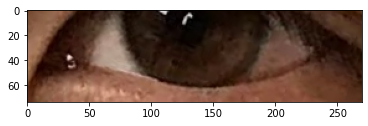

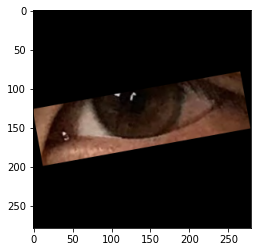

In [9]:
file = '../src/assets/rin.jpg'
path='../src/assets/'
img = cv2.imread(file)
(h, w, c) = img.shape

# 点番号用のカウント変数
cnt = 0

imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results = faceMesh.process((imgRGB))
if results.multi_face_landmarks:
  for faceLms in results.multi_face_landmarks:
    # このループが顔の点分(468)回繰り返される
    # 特定の顔の点を記載したときはこの部分を調整する
    for id, lm in enumerate(faceLms.landmark):
      if right_eye.judge(cnt):
        # 各パーツの配列に保存
        right_eye.store(lm, cnt)
      elif left_eye.judge(cnt):
        left_eye.store(lm, cnt)
      elif nose.judge(cnt):
        nose.store(lm, cnt)
      elif mouse.judge(cnt):
        mouse.store(lm, cnt)      
      cnt +=1

deg_right = math.degrees(convert_deg(right_eye.array[1], right_eye.array[3]))          
cutimg_right = rot_cut(imgRGB, deg_right, right_eye.array_center(), right_eye.array_size())
deg_left = math.degrees(convert_deg(left_eye.array[1], left_eye.array[3]))
cutimg_left = rot_cut(imgRGB, deg_left, left_eye.array_center(), left_eye.array_size())
deg_nose = math.degrees(convert_deg(nose.array[1], nose.array[3]))
cutimg_nose = rot_cut(imgRGB, deg_nose, nose.array_center(), nose.array_size())
deg_mouse = math.degrees(convert_deg(mouse.array[1], mouse.array[3]))
cutimg_mouse = rot_cut(imgRGB, deg_mouse, mouse.array_center(), mouse.array_size())

plt.imshow(cutimg_left)
plt.show()

(h, w, c) = cutimg_left.shape
reverse_canvas_size = int(math.sqrt(h*h + w*w))
reverse = cv2.getRotationMatrix2D([w/2, h/2], -deg_right, 1.0)
reverse[0][2] += int(reverse_canvas_size / 2) - (w/2) 
reverse[1][2] += int(reverse_canvas_size / 2) - (h/2)
revimg = cv2.warpAffine(cutimg_left, reverse, [reverse_canvas_size, reverse_canvas_size])
plt.imshow(revimg)
plt.show()